In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import sys
sys.path.append("../camp_scripts") # change accordingly
sns.set_context('notebook')

In [4]:
from june.demography.geography import Geography
from june.demography.demography import load_age_and_sex_generators_for_bins, Demography, Population
from june.paths import data_path
from june.infection_seed import InfectionSeed
from june.simulator import Simulator
from june.infection import InfectionSelector
from june.interaction import Interaction
from june.groups import Hospital, Hospitals
from june.distributors import HospitalDistributor
from june.hdf5_savers import generate_world_from_hdf5
from june.groups import Cemeteries
from june.policy import Policy, Policies
from june.logger.read_logger import ReadLogger

from camps.paths import camp_data_path
from camps.world import World
from camps.groups.leisure import generate_leisure_for_world, generate_leisure_for_config
from camp_creation import generate_empty_world, populate_world, distribute_people_to_households # this is loaded from the ../camp_scripts folder

No --data argument given - defaulting to:
/home/florpi/camps/JUNE/data
No --configs argument given - defaulting to:
/home/florpi/camps/JUNE/configs


2020-09-01 16:52:08,885 - camps.paths - WARNING - No --data argument given - defaulting to:
/home/florpi/camps/JUNE/data
2020-09-01 16:52:08,887 - camps.paths - WARNING - No --configs argument given - defaulting to:
/home/florpi/camps/JUNE/configs
2020-09-01 16:52:08,889 - camps.paths - WARNING - No --camp_data argument given - defaulting to:
/home/florpi/camps/JUNE/camp_data
2020-09-01 16:52:08,890 - camps.paths - WARNING - No --configs_camps argument given - defaulting to:
/home/florpi/camps/JUNE/configs_camps


In [5]:
from camps.groups import PumpLatrines, PumpLatrineDistributor
from camps.groups import DistributionCenters, DistributionCenterDistributor
from camps.groups import Communals, CommunalDistributor
from camps.groups import FemaleCommunals, FemaleCommunalDistributor
from camps.groups import Religiouss, ReligiousDistributor
from camps.groups import Shelter, Shelters, ShelterDistributor
from camps.groups import IsolationUnit, IsolationUnits
from june.groups.leisure import HouseholdVisitsDistributor
from camps.groups import PlayGroups, PlayGroupDistributor

## Initialize the world

In [6]:
# create empty world's geography
world = generate_empty_world(filter_key = {"region" : ["CXB-219"]})

2020-09-01 16:52:09,181 - june.demography.geography - INFO - There are 65 areas and 4 super_areas in the world.


In [7]:
# populate empty world
populate_world(world)

In [8]:
# distribute people to households
distribute_people_to_households(world)

In [9]:
# this is not working
hospitals= Hospitals.from_file(
    filename=camp_data_path / 'input/hospitals/hospitals.csv'
)
world.hospitals = hospitals
for hospital in world.hospitals:
    hospital.super_area = world.super_areas.members[0]
hospital_distributor = HospitalDistributor(hospitals, 
                                           medic_min_age=20,
                                           patients_per_medic=10)

hospital_distributor.distribute_medics_from_world(world.people)
world.isolation_units = IsolationUnits([IsolationUnit()])

2020-09-01 16:52:10,532 - june.groups.hospital - INFO - There are 8 hospitals in the world.


In [10]:
world.pump_latrines = PumpLatrines.for_areas(world.areas)
world.distribution_centers = DistributionCenters.for_areas(world.areas)
world.communals = Communals.for_areas(world.areas)
world.female_communals = FemaleCommunals.for_areas(world.areas)
world.religiouss = Religiouss.for_areas(world.areas)
world.play_groups = PlayGroups.for_areas(world.areas)

In [11]:
#world.box_mode = False
world.cemeteries = Cemeteries()

## Geography exploration

### UNHCR camp blocks inside the World

In [12]:
super_areas = []
for super_area in world.super_areas:
    super_areas.append(super_area.name)

In [13]:
super_areas[:5]

['CXB-219-A', 'CXB-219-B', 'CXB-219-C', 'CXB-219-D']

### Mahjee blocks inside World

In [14]:
areas = []
for area in world.areas:
    areas.append(area.name)

In [15]:
areas[:5]

['CXB-219-062', 'CXB-219-063', 'CXB-219-061', 'CXB-219-060', 'CXB-219-065']

## Demography exploration

### UNHCR block residents

In [16]:
sample_ages = []
sample_sexes = []
for person in world.super_areas.members[0].people:
    sample_ages.append(person.age)
    sample_sexes.append(person.sex)

In [17]:
sample_sexes[:5], sample_ages[:5]

(['f', 'f', 'f', 'm', 'm'], [27, 21, 57, 27, 46])

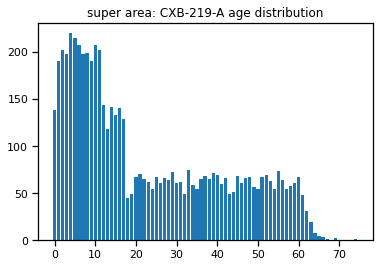

In [18]:
ages, counts = np.unique(sample_ages, return_counts=True)
plt.bar(ages, counts)
plt.title('super area: {} age distribution'.format(world.super_areas.members[0].name))
plt.show()

In [19]:
print ('The % children between ages 0-16 is {}%'.format(round(np.sum(counts[:16])/(np.sum(counts[:16])+np.sum(counts[16:]))*100)))

The % children between ages 0-16 is 49.0%


## Households

### Household size distribution

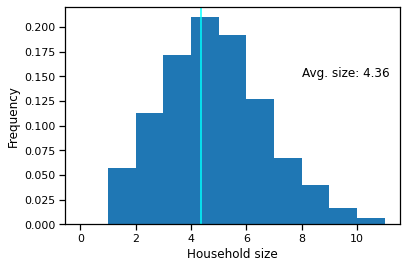

In [20]:
household_sizes = [household.size for household in world.households]
plt.hist(household_sizes, density=True, bins=np.arange(0,12))
plt.xlabel("Household size")
plt.ylabel("Frequency")
plt.axvline(np.mean(household_sizes), color="cyan")
plt.text(8, 0.150, f"Avg. size: {(np.mean(household_sizes)):.2f}")
plt.show()

# Shelters

In [21]:
world.shelters = Shelters.for_areas(world.areas)
shelter_distributor = ShelterDistributor(sharing_shelter_ratio = 0.75) # proportion of families that share a shelter
for area in world.areas:
    shelter_distributor.distribute_people_in_shelters(area.shelters, area.households)

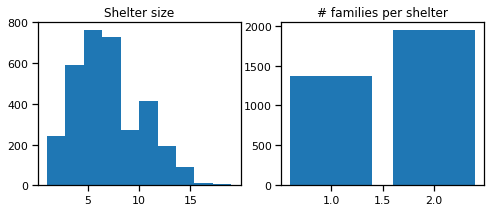

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(8,3))
shelter_sizes = [shelter.size for shelter in world.shelters]
shelter_families = [shelter.n_families for shelter in world.shelters]
ax[0].hist(shelter_sizes)
ax[0].set_title("Shelter size")
shelter_families = {1 : len([shelter for shelter in world.shelters if shelter.n_families == 1]),
                    2 : len([shelter for shelter in world.shelters if shelter.n_families == 2])}
ax[1].bar(shelter_families.keys(), shelter_families.values())
ax[1].set_title("# families per shelter")
plt.show()

## Activity exploration

### Pumps and latrines 

In [23]:
pumps_and_latrines = []
for pump_latrine in world.areas.members[0].pump_latrines:
    pumps_and_latrines.append(pump_latrine)

In [24]:
print ('There are {} pumps and latrines in area {}'.format(len(pumps_and_latrines), world.areas.members[0].name))

There are 3 pumps and latrines in area CXB-219-062


### Distribution centers

In [25]:
distribution_centers = []
for center in world.distribution_centers:
    distribution_centers.append(center)

In [26]:
distribution_centers[0].coordinates

array([21.1962 , 92.14936])

### Communal spaces

In [27]:
communal_spaces = []
for space in world.communals:
    communal_spaces.append(space)

In [28]:
communal_spaces[0].coordinates

array([21.19621, 92.14924])

### Female friendly communal spaces

In [29]:
female_communal_spaces = []
for space in world.female_communals:
    female_communal_spaces.append(space)

In [30]:
female_communal_spaces[0].coordinates

array([21.19588, 92.152  ])

### Religious sites

In [31]:
religious = []
for rel in world.religiouss:
    religious.append(rel)

In [32]:
religious[0].coordinates

array([21.20069, 92.15216])

# Adding the infection

In [33]:
selector = InfectionSelector.from_file()

# Adding the interaction

In [34]:
interaction = Interaction.from_file(config_filename='../configs_camps/defaults/interaction/ContactInteraction.yaml')

# Set policies

In [35]:
policies = Policies.from_file('../configs_camps/defaults/policy/policy.yaml', base_policy_modules=('june.policy', 'camps.policy'))

In [36]:
policies.policies

# Seed the disease

In [37]:
seed = InfectionSeed(world.super_areas,
           selector)

seed.unleash_virus(n_cases=5)

# Init leisure

In [38]:
CONFIG_PATH = "../configs_camps/config_example.yaml"

leisure_instance = generate_leisure_for_config(
            world=world, config_filename=CONFIG_PATH
)
leisure_instance.leisure_distributors = {}
leisure_instance.leisure_distributors['pump_latrines'] = PumpLatrineDistributor.from_config(pump_latrines=world.pump_latrines)
leisure_instance.leisure_distributors['distribution_centers'] = DistributionCenterDistributor.from_config(distribution_centers=world.distribution_centers)
leisure_instance.leisure_distributors['communals'] = CommunalDistributor.from_config(communals=world.communals)
leisure_instance.leisure_distributors['female_communals'] = FemaleCommunalDistributor.from_config(female_communals=world.female_communals)
leisure_instance.leisure_distributors['play_groups'] = PlayGroupDistributor.from_config(play_groups=world.play_groups)

#associate social activities to shelters
leisure_instance.distribute_social_venues_to_households(world.shelters, world.super_areas)
leisure_instance.leisure_distributors

2020-09-01 16:52:15,179 - june.groups.leisure.leisure - INFO - Distributing social venues to households
2020-09-01 16:52:15,180 - june.groups.leisure.leisure - INFO - Distributed in 0 of 3315 households.


{'pump_latrines': <camps.groups.pump_latrine.PumpLatrineDistributor at 0x7f771ca90130>,
 'distribution_centers': <camps.groups.distribution_center.DistributionCenterDistributor at 0x7f771ca903a0>,
 'communals': <camps.groups.communal.CommunalDistributor at 0x7f771ca90550>,
 'female_communals': <camps.groups.female_communal.FemaleCommunalDistributor at 0x7f771ca90a60>,
 'play_groups': <camps.groups.play_group.PlayGroupDistributor at 0x7f771ca90280>}

# Initialize simulator and run

In [45]:
simulator = Simulator.from_file(
    world = world,
    interaction = interaction,
    infection_selector=selector,
    leisure = leisure_instance,
    policies=policies,
    config_filename = CONFIG_PATH
)

In [46]:
%%time
simulator.run()

2020-09-01 16:53:46,859 - june.simulator - INFO - Starting group_dynamics for 120 days at day 0
2020-09-01 16:53:46,860 - june.simulator - INFO - starting the loop ..., at 0 days, to run for 120 days
2020-09-01 16:53:47,013 - june.simulator - INFO - Date = 2020-05-24 00:00:00, number of deaths =  0, number of infected = 5
2020-09-01 16:53:47,607 - june.simulator - INFO - Date = 2020-05-24 03:00:00, number of deaths =  0, number of infected = 5
2020-09-01 16:53:47,870 - june.simulator - INFO - Date = 2020-05-24 05:00:00, number of deaths =  0, number of infected = 5
2020-09-01 16:53:48,124 - june.simulator - INFO - Date = 2020-05-24 07:00:00, number of deaths =  0, number of infected = 5
2020-09-01 16:53:48,412 - june.simulator - INFO - Date = 2020-05-24 09:00:00, number of deaths =  0, number of infected = 5
2020-09-01 16:53:48,541 - june.simulator - INFO - Date = 2020-05-24 11:00:00, number of deaths =  0, number of infected = 5
2020-09-01 16:53:48,669 - june.simulator - INFO - Date =

2020-09-01 16:54:01,260 - june.simulator - INFO - Date = 2020-06-03 08:00:00, number of deaths =  0, number of infected = 207
2020-09-01 16:54:01,555 - june.simulator - INFO - Date = 2020-06-03 10:00:00, number of deaths =  0, number of infected = 213
2020-09-01 16:54:01,699 - june.simulator - INFO - Date = 2020-06-04 00:00:00, number of deaths =  0, number of infected = 232
2020-09-01 16:54:01,947 - june.simulator - INFO - Date = 2020-06-04 02:00:00, number of deaths =  0, number of infected = 239
2020-09-01 16:54:02,182 - june.simulator - INFO - Date = 2020-06-04 04:00:00, number of deaths =  0, number of infected = 246
2020-09-01 16:54:02,454 - june.simulator - INFO - Date = 2020-06-04 06:00:00, number of deaths =  0, number of infected = 256
2020-09-01 16:54:02,875 - june.simulator - INFO - Date = 2020-06-04 08:00:00, number of deaths =  0, number of infected = 269
2020-09-01 16:54:03,120 - june.simulator - INFO - Date = 2020-06-04 10:00:00, number of deaths =  0, number of infecte

2020-09-01 16:54:21,445 - june.simulator - INFO - Date = 2020-06-14 07:00:00, number of deaths =  0, number of infected = 5605
2020-09-01 16:54:22,040 - june.simulator - INFO - Date = 2020-06-14 09:00:00, number of deaths =  0, number of infected = 5838
2020-09-01 16:54:22,412 - june.simulator - INFO - Date = 2020-06-14 11:00:00, number of deaths =  0, number of infected = 6072


AttributeError: patients

# Getting the results

All results are stored in a json file specified in the ``save_path`` variable in the config file. We can also access it from ``world.logger`` directly.

In [47]:
import pandas as pd
read = ReadLogger()

In [48]:
read.load_infection_location()

In [49]:
infection_locations = read.get_locations_infections()

In [50]:
unique_locations, counts_locations = np.unique(
                np.array(infection_locations),
                return_counts=True)

location_counts_df = pd.DataFrame(
    {'locations': unique_locations,
    'counts': counts_locations}
)
location_counts_df.set_index('locations', inplace=True)


In [51]:
location_counts_df['percent_infections']= 100*(location_counts_df['counts'])/location_counts_df.values.sum()

Text(0.5, 0, 'location')

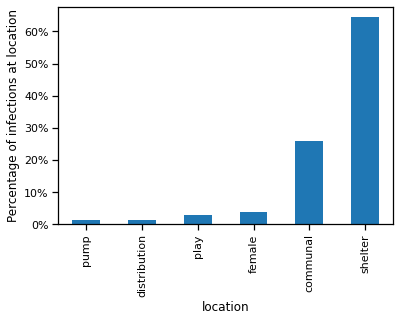

In [52]:
import matplotlib.ticker as mtick

ax = location_counts_df['percent_infections'].sort_values().plot.bar()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylabel('Percentage of infections at location')
plt.xlabel('location')

In [59]:
for location in unique_locations:
    read.locations_df[str(location)] = read.locations_df.apply(
        lambda x: x.location.count(str(location)), axis=1
    )
read.locations_df.index = pd.to_datetime(read.locations_df.index)

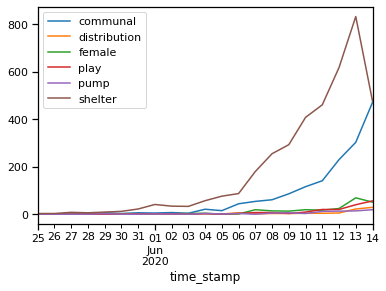

In [60]:
read.locations_df.iloc[:,3:].plot()

# Where did outbreaks happen?

In [53]:
unique_id, count_id =  np.unique(
        np.array(read.locations_df['location_id'].sum()),
        return_counts=True
)

In [54]:
unique_id[np.argsort(count_id)[-5:]]

array(['communal_101', 'communal_41', 'communal_69', 'communal_78',
       'communal_100'], dtype='<U22')

In [55]:
count_id[np.argsort(count_id)[-5:]]

array([25, 26, 26, 27, 32])

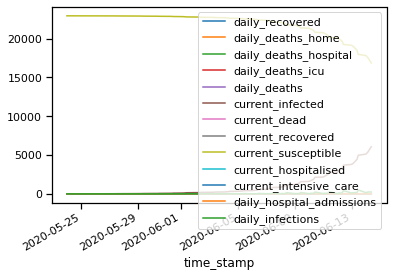

In [61]:
world_df = read.world_summary()
world_df.plot()
#plt.axvspan(policies.social_distancing_start, 
#            policies.social_distancing_end,
#            facecolor='y', alpha=0.2)
plt.legend()